In [ ]:
## Setup ## 
import tensorflow
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
import tensorflow as tf
import os,sys
import joblib
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [ ]:
# 분석에 필요한 함수 

def today():
  from datetime import datetime
  year = str(datetime.today().year)

  if datetime.today().month<10:
    month = str(0)+ str(datetime.today().month)
  else : month = str(datetime.today().month)

  if datetime.today().day<10:
    day = str(0)+ str(datetime.today().day)
  else : day = str(datetime.today().day)

  if (datetime.today().hour + 9)%24 < 10:
    hour = str(0)+ str((datetime.today().hour+9)%24)
  else : hour = str((datetime.today().hour+9)%24)

  if datetime.today().minute<10:
    min = str(0)+ str(datetime.today().minute)
  else : min = str(datetime.today().minute)


  return year+month+day+'_'+hour+'시'+min+'분'
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

def Directory(keyword):
  while True:
    try:
      base = '/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Recommendation Models/'
      directory=base + keyword+'/'
      if not os.path.exists(directory):
            os.makedirs(directory)
            os.chdir(directory)
            return directory
            break
      else:
        os.chdir(directory)
        return directory
        break
    except OSError:
      print ('Error: Creating directory. ' +  directory)
      continue
  return directory

from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def Recommend(uid,top_n):
  print(f'<{uid} 님을 위한 추천곡>\n')
  for (iid,est) in top_n[uid]:
    print(f'{iid} => {round(round(est,4)*100,2)} %의 확률로 좋아하실 거에요')

In [ ]:
#Surpirse 설치
!pip install surprise
import surprise
from surprise import BaselineOnly 
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, KNNWithZScore
from surprise import SVD,SVDpp
from surprise import SlopeOne, CoClustering
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

In [ ]:
# 데이터 불러오기 및 편집

data_dict = pd.read_excel(r"C:\Users\82102\Desktop\KU-BIG\Spotify\Spotify_Data.xlsx",sheet_name=None,header=0,index_col=0)
ratings = data_dict['Ratings']
tracks = data_dict['Track_Features']
display(ratings,tracks)

,1,2,3,4,5,6,7,8,9,10,...,153,154,155,156,157,158,159,160,161,162
도윤,1,0,1,1,0,1,1,0,1,0,...,1,1,1,1,0,0,0,1,1,1
도윤_Herng,1,0,1,0,0,0,0,-1,0,1,...,1,0,0,0,1,0,1,1,1,1
도윤__Melanie,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,1,1,1,-1,1,-1,-1,-1,-1,-1
도윤_JInju,1,-1,1,-1,1,-1,1,1,-1,1,...,1,0,-1,0,1,-1,1,-1,-1,1
도윤_Maya,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,-1,0,0,-1,0
도윤_MI,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,-1,1,1,1,1
도윤_Geraldine,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,1,1,0,1
도윤_Tiffany,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,1,1,1,1
형록1,-1,-1,-1,-1,-1,-1,0,1,1,1,...,-1,-1,1,-1,-1,-1,1,1,1,1
형록2,0,0,1,1,0,1,0,-1,-1,1,...,-1,1,1,0,1,0,1,1,1,1


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist
1,0.01980,0.571,199640,0.870,0.000007,8,0.0564,-3.877,0,0.0641,172.716,4,0.815,Bye Bye Bye,NSYNC
2,0.30000,0.550,266293,0.563,0.000000,2,0.1220,-7.019,1,0.0313,166.004,4,0.462,This I Promise You - Radio Edit,NSYNC
3,0.04790,0.647,191280,0.870,0.000000,0,0.0485,-4.702,0,0.0798,165.103,4,0.906,It's Gonna Be Me,NSYNC
4,0.44000,0.468,243493,0.535,0.000000,10,0.1010,-8.264,1,0.0436,168.001,4,0.298,God Must Have Spent a Little More Time on You ...,NSYNC
5,0.07430,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4,0.865,I Want You Back - Radio Edit,NSYNC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.26700,0.563,315787,0.847,0.000000,0,0.2430,-6.190,1,0.3250,82.757,4,0.810,Can I Touch You...There?,Michael Bolton
159,0.00574,0.682,192000,0.812,0.000000,1,0.0553,-2.691,0,0.1180,104.891,4,0.347,Shape of You (Major Lazer Remix) [feat. Nyla &...,Ed Sheeran
160,0.02020,0.333,174240,0.913,0.000000,2,0.1460,-3.722,1,0.0808,99.889,4,0.129,Paris - Pegboard Nerds Remix,The Chainsmokers
161,0.00087,0.465,265600,0.953,0.014600,8,0.2260,-4.684,0,0.2950,160.064,4,0.554,Don't Let Me Down - Zomboy Remix,The Chainsmokers


In [ ]:
#노래제목과 가수이름 합치기

temp = [title+'__'+artist for title,artist in zip(tracks.song_title,tracks.artist)]
track_ft = tracks.drop(['song_title','artist'],axis=1)
track_ft['track_name']=temp
display(track_ft)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_name
1,0.01980,0.571,199640,0.870,0.000007,8,0.0564,-3.877,0,0.0641,172.716,4,0.815,Bye Bye Bye__NSYNC
2,0.30000,0.550,266293,0.563,0.000000,2,0.1220,-7.019,1,0.0313,166.004,4,0.462,This I Promise You - Radio Edit__NSYNC
3,0.04790,0.647,191280,0.870,0.000000,0,0.0485,-4.702,0,0.0798,165.103,4,0.906,It's Gonna Be Me__NSYNC
4,0.44000,0.468,243493,0.535,0.000000,10,0.1010,-8.264,1,0.0436,168.001,4,0.298,God Must Have Spent a Little More Time on You ...
5,0.07430,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4,0.865,I Want You Back - Radio Edit__NSYNC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.26700,0.563,315787,0.847,0.000000,0,0.2430,-6.190,1,0.3250,82.757,4,0.810,Can I Touch You...There?__Michael Bolton
159,0.00574,0.682,192000,0.812,0.000000,1,0.0553,-2.691,0,0.1180,104.891,4,0.347,Shape of You (Major Lazer Remix) [feat. Nyla &...
160,0.02020,0.333,174240,0.913,0.000000,2,0.1460,-3.722,1,0.0808,99.889,4,0.129,Paris - Pegboard Nerds Remix__The Chainsmokers
161,0.00087,0.465,265600,0.953,0.014600,8,0.2260,-4.684,0,0.2950,160.064,4,0.554,Don't Let Me Down - Zomboy Remix__The Chainsmo...


In [ ]:
ratings = ratings.set_axis(track_ft.track_name,axis='columns')
ratings

track_name,Bye Bye Bye__NSYNC,This I Promise You - Radio Edit__NSYNC,It's Gonna Be Me__NSYNC,God Must Have Spent a Little More Time on You - Remix__NSYNC,I Want You Back - Radio Edit__NSYNC,Pop - Radio Version__NSYNC,Tearin' up My Heart - Radio Edit__NSYNC,Ciao Adios__Anne-Marie,Gary's Theme - Remastered__Bill Evans,Levels - Radio Edit__Avicii,...,SexyBack__Justin Timberlake,Fantasy__Mariah Carey,Remember the Time__Michael Jackson,Against All Odds (Take a Look at Me Now)__Mariah Carey,Earth Song - Remastered Version__Michael Jackson,Can I Touch You...There?__Michael Bolton,Shape of You (Major Lazer Remix) [feat. Nyla & Kranium]__Ed Sheeran,Paris - Pegboard Nerds Remix__The Chainsmokers,Don't Let Me Down - Zomboy Remix__The Chainsmokers,Something Just Like This - ARMNHMR Remix__The Chainsmokers
도윤,1,0,1,1,0,1,1,0,1,0,...,1,1,1,1,0,0,0,1,1,1
도윤_Herng,1,0,1,0,0,0,0,-1,0,1,...,1,0,0,0,1,0,1,1,1,1
도윤__Melanie,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,1,1,1,-1,1,-1,-1,-1,-1,-1
도윤_JInju,1,-1,1,-1,1,-1,1,1,-1,1,...,1,0,-1,0,1,-1,1,-1,-1,1
도윤_Maya,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,-1,0,0,-1,0
도윤_MI,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,-1,1,1,1,1
도윤_Geraldine,1,1,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,1,1,0,1
도윤_Tiffany,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,1,1,1,1
형록1,-1,-1,-1,-1,-1,-1,0,1,1,1,...,-1,-1,1,-1,-1,-1,1,1,1,1
형록2,0,0,1,1,0,1,0,-1,-1,1,...,-1,1,1,0,1,0,1,1,1,1


In [ ]:
# track,index

track2idx={name:i+1 for i, name in enumerate(track_ft.track_name)}
idx2track={i+1:name for i, name in enumerate(track_ft.track_name)}

user2idx={name:i+1 for i, name in enumerate(ratings.index)}
idx2user={i+1:name for i, name in enumerate(ratings.index)}


display(track2idx,user2idx)

{'Bye Bye Bye__NSYNC': 1,
 'This I Promise You - Radio Edit__NSYNC': 2,
 "It's Gonna Be Me__NSYNC": 3,
 'God Must Have Spent a Little More Time on You - Remix__NSYNC': 4,
 'I Want You Back - Radio Edit__NSYNC': 5,
 'Pop - Radio Version__NSYNC': 6,
 "Tearin' up My Heart - Radio Edit__NSYNC": 7,
 'Ciao Adios__Anne-Marie': 8,
 "Gary's Theme - Remastered__Bill Evans": 9,
 'Levels - Radio Edit__Avicii': 10,
 'On Bended Knee__Boyz II Men': 11,
 'End Of The Road__Boyz II Men': 12,
 "I'll Make Love To You__Boyz II Men": 13,
 'Water Runs Dry__Boyz II Men': 14,
 'A Song For Mama__Boyz II Men': 15,
 'As Long as You Love Me__Backstreet Boys': 16,
 'Quit Playing Games (With My Heart)__Backstreet Boys': 17,
 "I'll Never Break Your Heart__Backstreet Boys": 18,
 'All I Have to Give__Backstreet Boys': 19,
 'The Call__Backstreet Boys': 20,
 'I Want It That Way__Backstreet Boys': 27,
 'Show Me the Meaning of Being Lonely__Backstreet Boys': 22,
 'Shape of My Heart__Backstreet Boys': 23,
 'Take Me There - 

{'도윤': 1,
 '도윤_Herng': 2,
 '도윤__Melanie': 3,
 '도윤_JInju': 4,
 '도윤_Maya': 5,
 '도윤_MI': 6,
 '도윤_Geraldine': 7,
 '도윤_Tiffany': 8,
 '형록1': 9,
 '형록2': 10,
 '헝록3': 11,
 '형록4': 12,
 '창현_승련': 13,
 '창현': 14,
 '창현_세영': 15,
 '다연1': 16,
 '다연2': 17,
 '다연3': 18,
 '나윤1': 19,
 '나윤2': 20,
 '나윤3': 21,
 '나윤4': 22,
 '효진1': 23,
 '효진2': 24,
 '효진3': 25,
 '근호': 26,
 '주영': 27,
 '윤지현': 28,
 '금지헌': 29}

In [ ]:
users=[]
for user in ratings.index:
  users.extend([user]*len(ratings.columns))
 
tracks = list(ratings.columns)*len(ratings.index)
score=[]
for i in range(len(ratings.index)):
  for j in range(len(ratings.columns)):
    score.append(float(ratings.iloc[i,j]))
temp={'users':users,'tracks':tracks,'score':score}
data = pd.DataFrame(temp)
display(data.head(50))

,users,tracks,score
0,도윤,Bye Bye Bye__NSYNC,1.0
1,도윤,This I Promise You - Radio Edit__NSYNC,0.0
2,도윤,It's Gonna Be Me__NSYNC,1.0
3,도윤,God Must Have Spent a Little More Time on You ...,1.0
4,도윤,I Want You Back - Radio Edit__NSYNC,0.0
5,도윤,Pop - Radio Version__NSYNC,1.0
6,도윤,Tearin' up My Heart - Radio Edit__NSYNC,1.0
7,도윤,Ciao Adios__Anne-Marie,0.0
8,도윤,Gary's Theme - Remastered__Bill Evans,1.0
9,도윤,Levels - Radio Edit__Avicii,0.0


In [ ]:
from sklearn.utils import shuffle
import random
import csv
reader = Reader(rating_scale=(-1, 1))
TRAIN_SIZE = 0.8
data = shuffle(data,random_state=3)
data = shuffle(data,random_state=33)

cutoff = int(TRAIN_SIZE * len(data))
ratings_train = data.iloc[:cutoff]
ratings_test = data.iloc[cutoff:]
display(ratings_train,ratings_test)

,users,tracks,score
727,도윤_Maya,No Vacancy__OneRepublic,-1.0
4517,윤지현,Beat It - Single Version__Michael Jackson,1.0
2813,다연3,Started From the Bottom__Drake,-1.0
1629,헝록3,Levels - Radio Edit__Avicii,1.0
1359,형록1,Get Lucky - Daft Punk Remix__Daft Punk,1.0
...,...,...,...
1626,헝록3,Tearin' up My Heart - Radio Edit__NSYNC,-1.0
4102,근호,I Want You - Single Version__Marvin Gaye,1.0
2189,창현,Whippin (feat. Felix Snow)__Kiiara,0.0
2029,창현_승련,The One__The Chainsmokers,1.0


,users,tracks,score
143,도윤,Beat It - Single Version__Michael Jackson,1.0
2213,창현,Kyoto (feat. Sirah)__Skrillex,1.0
962,도윤_MI,SexyBack__Justin Timberlake,1.0
140,도윤,My Boo__Usher,1.0
3365,나윤3,"String Quintet in C Major, Op. 29: II. Adagio ...",-1.0
...,...,...,...
1208,도윤_Tiffany,Get Lucky__Daft Punk,0.0
1699,헝록3,No Vacancy__OneRepublic,1.0
2328,창현_세영,"Gone, Gone__Juicy J",-1.0
1569,형록2,What 2 Do__DEAN,1.0


In [ ]:
# The columns must correspond to user id, item id and ratings (in that order).
dataset = Dataset.load_from_df(data,reader)
Trainset = Dataset.load_from_df(ratings_train,reader)
Testset = Dataset.load_from_df(ratings_test,reader)
# Train/Test 분리
trainset,testset= train_test_split(dataset,train_size=0.8,random_state=3)
#len(trainset.all_items())

In [ ]:
#MF

# 1. Collaborative Filtering

## 1) Slope One

In [ ]:
# Select your best algo with grid search.
param_grid = {}
grid_search = GridSearchCV(SlopeOne, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
grid_search.fit(Trainset) # Grid search 할때는 dataset 전체로 우선 해줌

algo = grid_search.best_estimator['rmse']
algo.fit(trainset)

print(grid_search.best_params)
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
display(results_df) # 행의 개수는 grid search 한 경우의 수

predictions = algo.test(testset)
print('RMSE(testset)', end=' ')
round(accuracy.rmse(predictions),4)

{'rmse': {}}


,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.744585,0.757289,0.752391,0.753296,0.757226,0.752957,0.004637,1,0.011967,0.001669,0.068219,0.007969,{}


RMSE(testset) RMSE: 0.7591


0.7591

## 2) Co Clustering

In [ ]:
# parameter 조정 안 하고, default 값으로만 CoClustering
names = []
results = []

algo = CoClustering()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7684


0.7684205339558127

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_cltr_u': [1,2,3,4,5,6,7,8,9,10,11],
              'n_cltr_i': [2,3,4,5,6,7,8,9,10],
              'n_epochs': [50,60,70,80,90,100]}

gs = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=5,n_jobs=-1)
gs.fit(Trainset)

In [ ]:
print(gs.best_params)
results_df = pd.DataFrame.from_dict(gs.cv_results)
display(results_df) # 행의 개수는 grid search 한 경우의 수


{'rmse': {'n_cltr_u': 8, 'n_cltr_i': 2, 'n_epochs': 100}}


,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs
0,0.746907,0.756888,0.759123,0.754362,0.757577,0.754971,0.004315,24,0.204252,0.006951,0.007181,0.000977,"{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 50}",1,2,50
1,0.746907,0.756888,0.759123,0.754362,0.757577,0.754971,0.004315,49,0.234772,0.008166,0.006382,0.000489,"{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 60}",1,2,60
2,0.746907,0.756888,0.759123,0.754362,0.757577,0.754971,0.004315,47,0.271278,0.013608,0.007181,0.000977,"{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 70}",1,2,70
3,0.746907,0.756888,0.759123,0.754362,0.757577,0.754971,0.004315,43,0.357351,0.041229,0.006782,0.001163,"{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 80}",1,2,80
4,0.746907,0.756888,0.759123,0.754362,0.757577,0.754971,0.004315,52,0.424066,0.036281,0.006582,0.000488,"{'n_cltr_u': 1, 'n_cltr_i': 2, 'n_epochs': 90}",1,2,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.799548,0.813225,0.834305,0.803520,0.821087,0.814337,0.012500,592,1.076921,0.058967,0.012567,0.007208,"{'n_cltr_u': 11, 'n_cltr_i': 10, 'n_epochs': 60}",11,10,60
590,0.797846,0.852040,0.807164,0.802883,0.808604,0.813707,0.019529,590,1.308361,0.049772,0.009376,0.001493,"{'n_cltr_u': 11, 'n_cltr_i': 10, 'n_epochs': 70}",11,10,70
591,0.789338,0.803284,0.832182,0.776655,0.810544,0.802401,0.018908,562,1.525457,0.132095,0.008776,0.000978,"{'n_cltr_u': 11, 'n_cltr_i': 10, 'n_epochs': 80}",11,10,80
592,0.815295,0.818681,0.788789,0.822306,0.825638,0.814142,0.013142,591,1.669562,0.100266,0.009177,0.001469,"{'n_cltr_u': 11, 'n_cltr_i': 10, 'n_epochs': 90}",11,10,90


In [ ]:
algo = gs.best_estimator['rmse']
algo.fit(trainset)
# Compute unbiased accuracy on teset
predictions = algo.test(testset)
print('Unbiased accuracy on Test,', end=' ')
round(accuracy.rmse(predictions),4)

Unbiased accuracy on Test, RMSE: 0.7547


0.7547

## 3) KNN

### Basic

In [ ]:
#'name' ={'cosine','msd','pearson'}
from collections import defaultdict
sim_option_user_based=[]
sim_option_item_based=[]
for support in list(np.linspace(10,20,10,dtype=int)):
  for name in ['cosine','msd','pearson']:
      sim_options = {'name': name,
                'user_based': True,# compute  similarities between Users
                'min_support':support
        }
      sim_option_user_based.append(sim_options)
# Select your best algo with grid search.
item_param_grid = {'k': np.linspace(20,80,7,dtype=int),
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False],
                              'min_support':[2,3,4,5]}
              }

user_param_grid = {'k': [3,4,5,6],
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True],
                              'min_support':np.linspace(10,20,10,dtype=int)}
              }


param_grid={'item':item_param_grid,'user':user_param_grid}

results={}

for key,value in param_grid.items():
  print('--------------',key,'start --------------------')
  grid_search = GridSearchCV(KNNBasic, value, measures=['rmse'], cv=5)
  grid_search.fit(Trainset) # Grid search 할때는 dataset 전체로 우선 해줌

  algo = grid_search.best_estimator['rmse']
  algo.fit(trainset)
  best_params = grid_search.best_params 
  results_df = pd.DataFrame.from_dict(grid_search.cv_results)
  user=[trainset.to_raw_uid(i) for i in range(trainset.n_users)]
  item=[trainset.to_raw_iid(i) for i in range(trainset.n_items)]
  sim_matrix = algo.compute_similarities()
  if key=='user':
    sim_matrix = pd.DataFrame(sim_matrix,index=user,columns=user)
  elif key=='item':
    sim_matrix = pd.DataFrame(sim_matrix,index=item,columns=item)
  #display(results_df) # 행의 개수는 grid search 한 경우의 수

  # Compute biased accuracy on trainset
  predictions = algo.test(trainset.build_testset())
  train_loss = round(accuracy.rmse(predictions),4)
  print(f'Biased accuracy on Train :{train_loss}')
  

  # Compute unbiased accuracy on teset
  predictions = algo.test(testset)
  test_loss = round(accuracy.rmse(predictions),4)
  print(f'Unbiased accuracy on Test: {test_loss}')
  

  results[key]={}
  results[key]['model'] = algo
  results[key]['best_params']=best_params
  results[key]['results_df']=results_df
  results[key]['loss']={'train_loss':train_loss,'test_loss':test_loss}
  results[key]['sim_matrix']=sim_matrix
  print(f'--------{key} Done --------')

KNN['basic']=results

-------------- item start --------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

In [ ]:
#1) user_based 추천

model = KNN['basic']['user']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7668
<도윤 님을 위한 추천곡>

...Baby One More Time__Britney Spears => 100 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 100 %의 확률로 좋아하실 거에요
If I Were a Boy__Beyoncé => 100 %의 확률로 좋아하실 거에요
Shape of You (Major Lazer Remix) [feat. Nyla & Kranium]__Ed Sheeran => 100 %의 확률로 좋아하실 거에요
Counting Stars__OneRepublic => 100 %의 확률로 좋아하실 거에요


In [ ]:
#1) item_based 추천

model = KNN['basic']['item']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7432
<도윤 님을 위한 추천곡>

Counting Stars__OneRepublic => 61.48 %의 확률로 좋아하실 거에요
Remember the Time__Michael Jackson => 60.62 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 45.61 %의 확률로 좋아하실 거에요
Rollin__Calvin Harris => 43.66 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 40.84 %의 확률로 좋아하실 거에요


### Means

In [ ]:
#'name' ={'cosine','msd','pearson'}
from collections import defaultdict
sim_option_user_based=[]
sim_option_item_based=[]
for support in list(np.linspace(10,20,10,dtype=int)):
  for name in ['cosine','msd','pearson']:
      sim_options = {'name': name,
                'user_based': True,# compute  similarities between Users
                'min_support':support
        }
      sim_option_user_based.append(sim_options)
# Select your best algo with grid search.
item_param_grid = {'k': np.linspace(20,80,7,dtype=int),
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False],
                              'min_support':[2,3,4,5]}
              }

user_param_grid = {'k': [3,4,5,6],
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True],
                              'min_support':np.linspace(10,20,10,dtype=int)}
              }


param_grid={'item':item_param_grid,'user':user_param_grid}

results={}

for key,value in param_grid.items():
  print('--------------',key,'start --------------------')
  grid_search = GridSearchCV(KNNWithMeans, value, measures=['rmse'], cv=5)
  grid_search.fit(Trainset) 

  algo = grid_search.best_estimator['rmse']
  algo.fit(trainset)
  best_params = grid_search.best_params 
  results_df = pd.DataFrame.from_dict(grid_search.cv_results)
  user=[trainset.to_raw_uid(i) for i in range(trainset.n_users)]
  item=[trainset.to_raw_iid(i) for i in range(trainset.n_items)]
  sim_matrix = algo.compute_similarities()
  if key=='user':
    sim_matrix = pd.DataFrame(sim_matrix,index=user,columns=user)
  elif key=='item':
    sim_matrix = pd.DataFrame(sim_matrix,index=item,columns=item)
  #display(results_df) # 행의 개수는 grid search 한 경우의 수

  # Compute biased accuracy on trainset
  predictions = algo.test(trainset.build_testset())
  train_loss = round(accuracy.rmse(predictions),4)
  print(f'Biased accuracy on Train :{train_loss}')
  

  # Compute unbiased accuracy on teset
  predictions = algo.test(testset)
  test_loss = round(accuracy.rmse(predictions),4)
  print(f'Unbiased accuracy on Test: {test_loss}')
  

  results[key]={}
  results[key]['model'] = algo
  results[key]['best_params']=best_params
  results[key]['results_df']=results_df
  results[key]['loss']={'train_loss':train_loss,'test_loss':test_loss}
  results[key]['sim_matrix']=sim_matrix
  print(f'--------{key} Done --------')

KNN['w_means']=results

-------------- item start --------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

In [ ]:
#1) user_based 추천

model = KNN['w_means']['user']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7514
<도윤 님을 위한 추천곡>

Black or White - Single Version__Michael Jackson => 100 %의 확률로 좋아하실 거에요
Rollin__Calvin Harris => 100 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 100 %의 확률로 좋아하실 거에요
Counting Stars__OneRepublic => 100 %의 확률로 좋아하실 거에요
SexyBack__Justin Timberlake => 95.9 %의 확률로 좋아하실 거에요


In [ ]:
#1) item_based 추천

model = KNN['w_means']['item']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7381
<도윤 님을 위한 추천곡>

Counting Stars__OneRepublic => 72.58 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 61.78 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 61.18 %의 확률로 좋아하실 거에요
...Baby One More Time__Britney Spears => 61.08 %의 확률로 좋아하실 거에요
If I Were a Boy__Beyoncé => 58.81 %의 확률로 좋아하실 거에요


### Z- Score

In [ ]:
#'name' ={'cosine','msd','pearson'}
from collections import defaultdict
sim_option_user_based=[]
sim_option_item_based=[]
for support in list(np.linspace(10,20,10,dtype=int)):
  for name in ['cosine','msd','pearson']:
      sim_options = {'name': name,
                'user_based': True,# compute  similarities between Users
                'min_support':support
        }
      sim_option_user_based.append(sim_options)
# Select your best algo with grid search.
item_param_grid = {'k': np.linspace(20,80,7,dtype=int),
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False],
                              'min_support':[2,3,4,5]}
              }

user_param_grid = {'k': [3,4,5,6],
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True],
                              'min_support':np.linspace(10,20,10,dtype=int)}
              }


param_grid={'item':item_param_grid,'user':user_param_grid}

results={}

for key,value in param_grid.items():
  print('--------------',key,'start --------------------')
  grid_search = GridSearchCV(KNNWithZScore, value, measures=['rmse'], cv=5)
  grid_search.fit(dataset) # Grid search 할때는 dataset 전체로 우선 해줌

  algo = grid_search.best_estimator['rmse']
  algo.fit(trainset)
  best_params = grid_search.best_params 
  results_df = pd.DataFrame.from_dict(grid_search.cv_results)
  user=[trainset.to_raw_uid(i) for i in range(trainset.n_users)]
  item=[trainset.to_raw_iid(i) for i in range(trainset.n_items)]
  sim_matrix = algo.compute_similarities()
  if key=='user':
    sim_matrix = pd.DataFrame(sim_matrix,index=user,columns=user)
  elif key=='item':
    sim_matrix = pd.DataFrame(sim_matrix,index=item,columns=item)
  #display(results_df) # 행의 개수는 grid search 한 경우의 수

  # Compute biased accuracy on trainset
  predictions = algo.test(trainset.build_testset())
  train_loss = round(accuracy.rmse(predictions),4)
  print(f'Biased accuracy on Train :{train_loss}')
  

  # Compute unbiased accuracy on teset
  predictions = algo.test(testset)
  test_loss = round(accuracy.rmse(predictions),4)
  print(f'Unbiased accuracy on Test: {test_loss}')
  

  results[key]={}
  results[key]['model'] = algo
  results[key]['best_params']=best_params
  results[key]['results_df']=results_df
  results[key]['loss']={'train_loss':train_loss,'test_loss':test_loss}
  results[key]['sim_matrix']=sim_matrix
  print(f'--------{key} Done --------')

KNN['w_zscore']=results

-------------- item start --------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

In [ ]:
#1) user_based 추천

model = KNN['w_zscore']['user']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7494
<도윤 님을 위한 추천곡>

Counting Stars__OneRepublic => 89.25 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 88.38 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 84.01 %의 확률로 좋아하실 거에요
Rollin__Calvin Harris => 80.91 %의 확률로 좋아하실 거에요
SexyBack__Justin Timberlake => 79.46 %의 확률로 좋아하실 거에요


In [ ]:
#1) item_based 추천

model = KNN['w_zscore']['item']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('도윤',top_n)

RMSE: 0.7405
<도윤 님을 위한 추천곡>

Counting Stars__OneRepublic => 69.99 %의 확률로 좋아하실 거에요
Something Just Like This - Don Diablo Remix__The Chainsmokers => 62.58 %의 확률로 좋아하실 거에요
Beat It - Single Version__Michael Jackson => 61.19 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 59.04 %의 확률로 좋아하실 거에요
...Baby One More Time__Britney Spears => 58.14 %의 확률로 좋아하실 거에요


### Baseline

In [ ]:
from collections import defaultdict
sim_option_user_based=[]
sim_option_item_based=[]
for support in list(np.linspace(10,20,10,dtype=int)):
  for name in ['cosine','msd','pearson']:
      sim_options = {'name': name,
                'user_based': True,# compute  similarities between Users
                'min_support':support
        }
      sim_option_user_based.append(sim_options)
    
# Select your best algo with grid search.
item_param_grid = {'k': np.linspace(20,80,7,dtype=int),
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False],
                              'min_support':[2,3,4,5]}
              }

user_param_grid = {'k': [3,4,5,6],
              'sim_options': {'name': ['pearson','msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True],
                              'min_support':np.linspace(10,20,10,dtype=int)}
              }


param_grid={'item':item_param_grid,'user':user_param_grid}

results={}

for key,value in param_grid.items():
  print('--------------',key,'start --------------------')
  grid_search = GridSearchCV(KNNBaseline, value, measures=['rmse'], cv=5)
  grid_search.fit(dataset) # Grid search 할때는 dataset 전체로 우선 해줌

  algo = grid_search.best_estimator['rmse']
  algo.fit(trainset)
  best_params = grid_search.best_params 
  results_df = pd.DataFrame.from_dict(grid_search.cv_results)
  user=[trainset.to_raw_uid(i) for i in range(trainset.n_users)]
  item=[trainset.to_raw_iid(i) for i in range(trainset.n_items)]
  sim_matrix = algo.compute_similarities()
  if key=='user':
    sim_matrix = pd.DataFrame(sim_matrix,index=user,columns=user)
  elif key=='item':
    sim_matrix = pd.DataFrame(sim_matrix,index=item,columns=item)
  #display(results_df) # 행의 개수는 grid search 한 경우의 수

  # Compute biased accuracy on trainset
  predictions = algo.test(trainset.build_testset())
  train_loss = round(accuracy.rmse(predictions),4)
  print(f'Biased accuracy on Train :{train_loss}')
  

  # Compute unbiased accuracy on teset
  predictions = algo.test(testset)
  test_loss = round(accuracy.rmse(predictions),4)
  print(f'Unbiased accuracy on Test: {test_loss}')
  

  results[key]={}
  results[key]['model'] = algo
  results[key]['best_params']=best_params
  results[key]['results_df']=results_df
  results[key]['loss']={'train_loss':train_loss,'test_loss':test_loss}
  results[key]['sim_matrix']=sim_matrix
  print(f'--------{key} Done --------')

KNN['w_baseline']=results

-------------- item start --------------------
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing 

In [ ]:
#1) user_based 추천
model = KNN['w_baseline']['user']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('창현',top_n)

RMSE: 0.7545
<창현 님을 위한 추천곡>

If I Were a Boy__Beyoncé => 92.72 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 90.56 %의 확률로 좋아하실 거에요
Maps__Maroon 5 => 88.67 %의 확률로 좋아하실 거에요
So Sick__Ne-Yo => 79.27 %의 확률로 좋아하실 거에요
Know Yourself__Drake => 66.23 %의 확률로 좋아하실 거에요


In [ ]:
#1) item_based 추천
model = KNN['w_baseline']['item']['model']
predictions = model.test(testset)
test_loss = round(accuracy.rmse(predictions),4)
top_n = get_top_n(predictions,5)
Recommend('창현',top_n)

RMSE: 0.7317
<창현 님을 위한 추천곡>

So Sick__Ne-Yo => 93.55 %의 확률로 좋아하실 거에요
If I Were a Boy__Beyoncé => 79.19 %의 확률로 좋아하실 거에요
Hotline Bling__Drake => 69.86 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 69.17 %의 확률로 좋아하실 거에요
I'm the One__DJ Khaled => 69.07 %의 확률로 좋아하실 거에요


In [ ]:
## KNN Result

print('KNN_user_Basic_User :',KNN['basic']['user']['loss'])
print('KNN_user_With_Means_User :', KNN['w_means']['user']['loss'])
print('KNN_user_With_Z-Score_User:', KNN['w_zscore']['user']['loss'])
print('KNN_user_With_Baseline_User:', KNN['w_baseline']['user']['loss'])
print()
print('KNN_item_Basic_Item :',KNN['basic']['item']['loss'])
print('KNN_item_With_Means_Item :', KNN['w_means']['item']['loss'])
print('KNN_item_With_Z-Score_Item:', KNN['w_zscore']['item']['loss'])
print('KNN_user_With_Baseline_Item:', KNN['w_baseline']['item']['loss'])

KNN_user_Basic_User : {'train_loss': 0.4448, 'test_loss': 0.7668}
KNN_user_With_Means_User : {'train_loss': 0.3925, 'test_loss': 0.7514}
KNN_user_With_Z-Score_User: {'train_loss': 0.3896, 'test_loss': 0.7494}
KNN_user_With_Baseline_User: {'train_loss': 0.5208, 'test_loss': 0.7545}

KNN_item_Basic_Item : {'train_loss': 0.4645, 'test_loss': 0.7432}
KNN_item_With_Means_Item : {'train_loss': 0.4972, 'test_loss': 0.7381}
KNN_item_With_Z-Score_Item: {'train_loss': 0.4924, 'test_loss': 0.7405}
KNN_user_With_Baseline_Item: {'train_loss': 0.4417, 'test_loss': 0.7317}


In [ ]:
data_dict = pd.read_excel(r"C:\Users\82102\Desktop\KU-BIG\Spotify\Spotify_Data.xlsx",sheet_name=None,header=0,index_col=0)
user_name = data_dict['Ratings'].iloc[:,0]
track_name = data_dict['Track_Features'].iloc[:,0]
#ratings = data_dict['Ratings'].drop(['users'],axis=1)

# 2. Matrix Factorization

## 1) SVD(MF) : with GridSearch

In [ ]:
# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_epochs': [18,19,20,22,24,26,28,30], 'lr_all': np.linspace(0.04,0.05,10)}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5,n_jobs=-1)
grid_search.fit(Trainset) # Grid search 할때는 dataset 전체로 우선 해줌

algo = grid_search.best_estimator['rmse']
algo.fit(trainset)

print(grid_search.best_params)
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
display(results_df) # 행의 개수는 grid search 한 경우의 수

# Compute unbiased accuracy on teset
predictions = algo.test(testset)
print('Unbiased accuracy on Test,', end=' ')
round(accuracy.rmse(predictions),4)



Grid Search...
{'rmse': {'n_epochs': 30, 'lr_all': 0.044444444444444446}}


,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all
0,0.751864,0.738493,0.748530,0.732345,0.756419,0.745530,0.008844,71,0.338199,0.055390,0.011220,0.004643,"{'n_epochs': 18, 'lr_all': 0.04}",18,0.040000
1,0.767146,0.742116,0.745589,0.732128,0.756362,0.748668,0.012055,80,0.350087,0.029314,0.008499,0.000083,"{'n_epochs': 18, 'lr_all': 0.04111111111111111}",18,0.041111
2,0.766766,0.723610,0.742865,0.732878,0.757534,0.744731,0.015745,67,0.367143,0.020522,0.010429,0.002550,"{'n_epochs': 18, 'lr_all': 0.042222222222222223}",18,0.042222
3,0.773473,0.729934,0.743548,0.736350,0.744480,0.745557,0.014922,72,0.376354,0.030468,0.008550,0.000061,"{'n_epochs': 18, 'lr_all': 0.043333333333333335}",18,0.043333
4,0.770497,0.735165,0.748224,0.716155,0.760427,0.746094,0.019085,76,0.373049,0.010408,0.009954,0.002575,"{'n_epochs': 18, 'lr_all': 0.044444444444444446}",18,0.044444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.757142,0.722798,0.727886,0.728157,0.742586,0.735714,0.012582,3,0.581038,0.039139,0.008969,0.000538,"{'n_epochs': 30, 'lr_all': 0.04555555555555556}",30,0.045556
76,0.755847,0.728046,0.747244,0.731528,0.738566,0.740246,0.010198,31,0.583882,0.033989,0.009639,0.001811,"{'n_epochs': 30, 'lr_all': 0.04666666666666667}",30,0.046667
77,0.757271,0.719771,0.736893,0.722119,0.744579,0.736127,0.014020,5,0.579106,0.026221,0.010371,0.002751,"{'n_epochs': 30, 'lr_all': 0.04777777777777778}",30,0.047778
78,0.753864,0.724427,0.734568,0.721100,0.747199,0.736232,0.012667,6,0.582613,0.040816,0.009020,0.000567,"{'n_epochs': 30, 'lr_all': 0.04888888888888889}",30,0.048889


Unbiased accuracy on Test, RMSE: 0.7138


0.7138

In [ ]:
import pickle
from sklearn.externals import joblib
directory=Directory('SVD')
fname=f'{directory}{today()}_SVD.pkl'
print(fname)
joblib.dump(algo, fname) 

/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Recommendation Models/SVD/20210404_17시39분_SVD.pkl


['/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Recommendation Models/SVD/20210404_17시39분_SVD.pkl']

In [ ]:
fname='/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Recommendation Models/SVD/20210404_11시40분_SVD.pkl'

rcm_from_joblib = joblib.load(fname)
predictions = rcm_from_joblib.test(testset)
test_loss = round(accuracy.rmse(predictions),4)

top_n = get_top_n(predictions,5)
Recommend('윤지현',top_n)


RMSE: 0.2656
<윤지현 (a.k.a. 윤영롱) 님을 위한 추천곡>

Maps__Maroon 5 => 97.3 %의 확률로 좋아하실 거에요
Black or White - Single Version__Michael Jackson => 96.22 %의 확률로 좋아하실 거에요
Shape of You__Ed Sheeran => 95.61 %의 확률로 좋아하실 거에요
Get Lucky - Radio Edit__Daft Punk => 95.11 %의 확률로 좋아하실 거에요
...Baby One More Time__Britney Spears => 94.36 %의 확률로 좋아하실 거에요


## 2) Neural Network

In [ ]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten ,ReLU, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.optimizers import SGD, Adamax,Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.layers import Dense, Concatenate, Activation

### 데이터셋 구성

In [ ]:
DATA_PATH = '/gdrive/Shareddrives/Spotify Recommendation/Spotify_Data.xlsx'
data_dict = pd.read_excel(DATA_PATH,sheet_name=None,header=0,index_col=None)

#display(data_dict['Ratings'])
user_name = data_dict['Ratings'].iloc[:,0]
track_name = data_dict['Track_Features'].iloc[:,0]
ratings = data_dict['Ratings'].drop(['users'],axis=1)
ratings = ratings.set_axis(np.linspace(0,161,162,dtype=int),axis=1)
tracks = data_dict['Track_Features'].drop(['Unnamed: 0'],axis=1)
# track,index
track2idx={name:i for i, name in enumerate(list(track_ft['track_name']))}
idx2track={i:name for i, name in enumerate(list(track_ft['track_name']))}

user2idx={name:i for i, name in enumerate(user_name)}
idx2user={i:name for i, name in enumerate(user_name)}


display(ratings)

track2idx

In [ ]:
track_ft['track_name']

1                                     Bye Bye Bye__NSYNC
2                 This I Promise You - Radio Edit__NSYNC
3                                It's Gonna Be Me__NSYNC
4      God Must Have Spent a Little More Time on You ...
5                    I Want You Back - Radio Edit__NSYNC
                             ...                        
158             Can I Touch You...There?__Michael Bolton
159    Shape of You (Major Lazer Remix) [feat. Nyla &...
160       Paris - Pegboard Nerds Remix__The Chainsmokers
161    Don't Let Me Down - Zomboy Remix__The Chainsmo...
162    Something Just Like This - ARMNHMR Remix__The ...
Name: track_name, Length: 162, dtype: object

In [ ]:
track2idx

{'$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)__Lil Dicky': 128,
 '(You Drive Me) Crazy__Britney Spears': 27,
 '...Baby One More Time__Britney Spears': 25,
 '0 To 100 / The Catch Up__Drake': 70,
 'A Song For Mama__Boyz II Men': 14,
 'Against All Odds (Take a Look at Me Now)__Mariah Carey': 155,
 'All Day__Kanye West': 41,
 'All I Have to Give__Backstreet Boys': 18,
 'Antidote__Travis Scott': 54,
 'As Long as You Love Me__Backstreet Boys': 15,
 'Bangarang (feat. Sirah)__Skrillex': 103,
 'Beat It - Single Version__Michael Jackson': 143,
 'Best I Ever Had__Drake': 100,
 'Big Rings__Drake': 42,
 'Billie Jean__Michael Jackson': 142,
 'Black Skinhead__Kanye West': 75,
 'Black or White - Single Version__Michael Jackson': 144,
 'Blood On The Leaves__Kanye West': 49,
 'Bounce It__Juicy J': 64,
 'Bound 2__Kanye West': 69,
 'Break Up Every Night__The Chainsmokers': 84,
 "Breakn' A Sweat__Skrillex": 104,
 'Bye Bye Bye__NSYNC': 0,
 'Can I Touch You...There?__Michael Bolton': 157,
 'Chicken So

In [ ]:
users=[]
for user in ratings.index:
  users.extend([user]*len(ratings.columns))
 
tracks = list(ratings.columns)*len(ratings.index)
score=[]
for i in range(len(ratings.index)):
  for j in range(len(ratings.columns)):
    score.append(float(ratings.iloc[i,j]))
temp={'users':users,'tracks':tracks,'score':score}
data = pd.DataFrame(temp)
display(data.head(50))

,users,tracks,score
0,0,0,1.0
1,0,1,0.0
2,0,2,1.0
3,0,3,1.0
4,0,4,0.0
5,0,5,1.0
6,0,6,1.0
7,0,7,0.0
8,0,8,1.0
9,0,9,0.0


In [ ]:
from sklearn.utils import shuffle
TRAIN_SIZE = 0.8
data = shuffle(data,random_state=3)
data = shuffle(data,random_state=33)

test_cutoff = int(TRAIN_SIZE * len(data))
ratings_train = data.iloc[:test_cutoff]
ratings_test = data.iloc[test_cutoff:]

valid_cutoff = int(0.5*len(ratings_test))
ratings_test=shuffle(ratings_test,random_state=33)
ratings_valid = ratings_test.iloc[:valid_cutoff]
ratings_test = ratings_test.iloc[valid_cutoff:]
display(ratings_train,ratings_test,ratings_valid)

,users,tracks,score
3797,23,71,-1.0
2162,13,56,0.0
1297,8,1,-1.0
2825,17,71,-1.0
1199,7,65,1.0
...,...,...,...
2752,16,160,1.0
364,2,40,-1.0
618,3,132,1.0
4371,26,159,1.0


,users,tracks,score
4108,25,58,1.0
4401,27,27,1.0
1961,12,17,-1.0
1167,7,33,0.0
2730,16,138,0.0
...,...,...,...
3197,19,119,1.0
4148,25,98,1.0
4204,25,154,-1.0
4243,26,31,1.0


,users,tracks,score
3091,19,13,0.0
669,4,21,0.0
117,0,117,0.0
4575,28,39,-1.0
2420,14,152,1.0
...,...,...,...
97,0,97,0.0
4012,24,124,1.0
2297,14,29,1.0
233,1,71,0.0


In [ ]:
# Variable 초기화                      # Latent factor 수 
mu = round(ratings_train.score.mean(),4)  # 전체 평균 
M = len(ratings.index)    # Number of users
N = len(ratings.columns) # Number of movies
mu,M,N      

(0.2743, 29, 162)

In [ ]:
# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

### Modelling

### (1) Baseline 

------------------------------------------------------------------
Init = GlorotNormal
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 1, 10)        290         input_23[0][0]                   
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 1, 10)        1620        input_24[0][0]                   
____

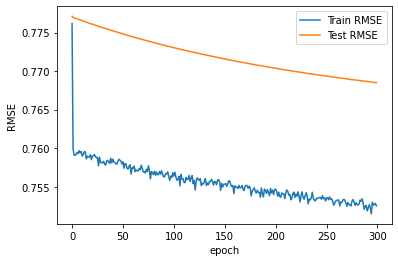

K=10 / Init = GlorotNormal / min_loss = 0.768501877784729
------------------------------------------------------------------
Init = GlorotNormal
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 1, 11)        319         input_25[0][0]                   
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 1, 11)

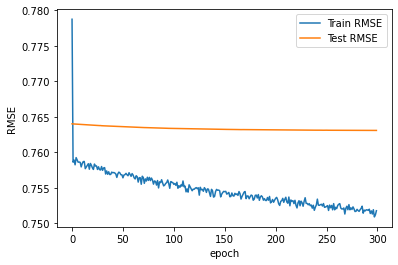

K=11 / Init = GlorotNormal / min_loss = 0.763107180595398
------------------------------------------------------------------
Init = GlorotNormal
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 1, 12)        348         input_27[0][0]                   
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 1, 12)

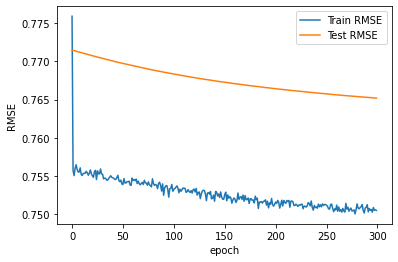

K=12 / Init = GlorotNormal / min_loss = 0.7651875615119934
------------------------------------------------------------------
Init = GlorotNormal
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 1, 13)        377         input_29[0][0]                   
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 1, 13

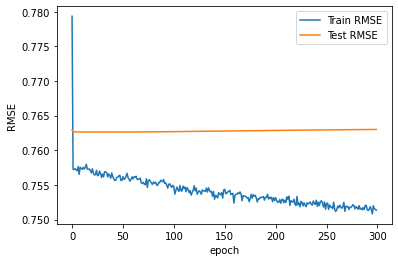

K=13 / Init = GlorotNormal / min_loss = 0.7626311779022217
------------------------------------------------------------------
Init = GlorotNormal
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 1, 14)        406         input_31[0][0]                   
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 1, 14

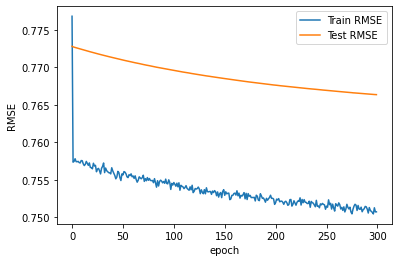

K=14 / Init = GlorotNormal / min_loss = 0.7663712501525879
------------------------------------------------------------------
Init = GlorotNormal
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_64 (Embedding)        (None, 1, 15)        435         input_33[0][0]                   
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 1, 15

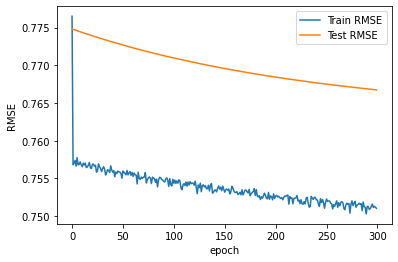

K=15 / Init = GlorotNormal / min_loss = 0.7667545676231384
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_68 (Embedding)        (None, 1, 10)        290         input_35[0][0]                   
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 1, 1

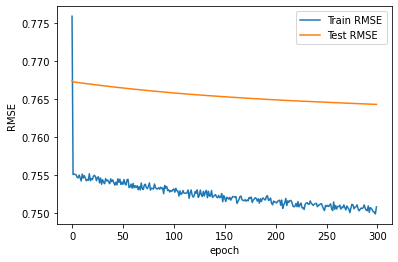

K=10 / Init = GlorotUniform / min_loss = 0.7642785906791687
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_72 (Embedding)        (None, 1, 11)        319         input_37[0][0]                   
__________________________________________________________________________________________________
embedding_73 (Embedding)        (None, 1, 

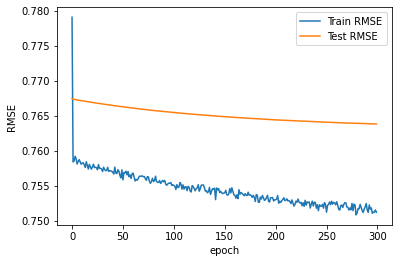

K=11 / Init = GlorotUniform / min_loss = 0.7638276219367981
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 1, 12)        348         input_39[0][0]                   
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 1, 

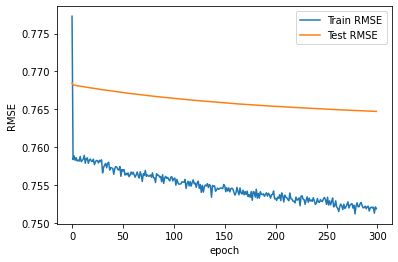

K=12 / Init = GlorotUniform / min_loss = 0.7647413015365601
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 1, 13)        377         input_41[0][0]                   
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 1, 

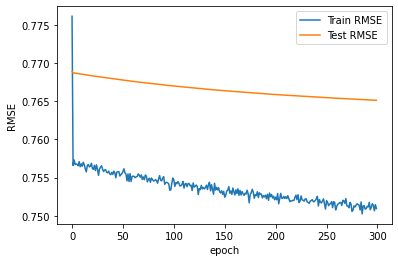

K=13 / Init = GlorotUniform / min_loss = 0.765123188495636
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_84 (Embedding)        (None, 1, 14)        406         input_43[0][0]                   
__________________________________________________________________________________________________
embedding_85 (Embedding)        (None, 1, 1

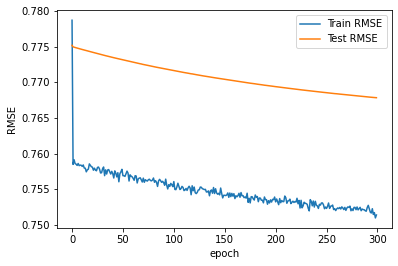

K=14 / Init = GlorotUniform / min_loss = 0.767848014831543
------------------------------------------------------------------
Init = GlorotUniform
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_88 (Embedding)        (None, 1, 15)        435         input_45[0][0]                   
__________________________________________________________________________________________________
embedding_89 (Embedding)        (None, 1, 1

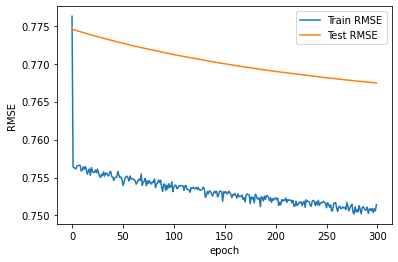

K=15 / Init = GlorotUniform / min_loss = 0.7674558162689209


In [ ]:
NN_Models=defaultdict(dict)
#1차 범위 : 5,10,15,..,30 : 10,15가 최소
#2차 범위 : 10,11,12,13,14,15 : 13이 최소 => 에폭수 1000으로 설정했음 : 50부터 증가 하는데 그래서 100까지로 삼으면 될듯 싶음

epochs = 300
PREVIOUS=10
for initializer in ['GlorotNormal','GlorotUniform']:
  for K in range(10,15+1):  
    print('------------------------------------------------------------------')
    print(f'Init = {initializer}')
    # Keras model
    user = Input(shape=(1, ))                                               # User input
    item = Input(shape=(1, ))                                               # Item input
    P_embedding = Embedding(M, K,embeddings_initializer=initializer, embeddings_regularizer=l2())(user)        # (M, 1, K)
    Q_embedding = Embedding(N, K,embeddings_initializer=initializer, embeddings_regularizer=l2())(item)        # (N, 1, K)
    user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
    item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

    #R = Dot(axes=2)([P_embedding, Q_embedding)
    R = layers.dot([P_embedding, Q_embedding], axes=2)                      # (1, 1, 1)
    #R = Add()([R, user_bias, item_bias])
    R = layers.add([R, user_bias, item_bias])
    R = Flatten()(R)                                                        # (1, 1)


    # Model setting
    starter_learning_rate = 0.1
    end_learning_rate = 0.0001
    decay_steps = int(0.1*epochs)
    learning_rate_fn = PolynomialDecay(
        starter_learning_rate,
        decay_steps,
        end_learning_rate,
        power=0.1)
    model = Model(inputs=[user, item], outputs=R)

    model.compile(
      loss=RMSE,
      optimizer=SGD(learning_rate=learning_rate_fn,momentum=0.9),
      #optimizer=Adamax(),
      metrics=[RMSE],
      
    )
    model.summary()

    # Model fitting
    result = model.fit(
      x=[ratings_train.users.values, ratings_train.tracks.values],
      y=ratings_train.score.values - mu,
      epochs=epochs,
      batch_size=64,
      validation_data=(
        [ratings_valid.users.values, ratings_valid.tracks.values],
        ratings_valid.score.values - mu
      )
    )

      # Plot RMSE
    plt.plot(result.history['RMSE'], label="Train RMSE")
    plt.plot(result.history['val_RMSE'], label="Test RMSE")
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    
    MIN= min(result.history['val_RMSE'])
    
    if MIN < PREVIOUS:
      try:  
        NN_Models[initializer]['K']=K
        NN_Models[initializer]['model']= model
        NN_Models[initializer]['loss'] = result.history['val_RMSE']
        NN_Models[initializer]['min_loss'] = MIN
        PREVIOUS = MIN
      except:
        continue
    
    print(f'K={K} / Init = {initializer} / min_loss = {MIN}')

In [ ]:
NN_Models['GlorotNormal'].items()
# K =13, min_loss = 0.7626

dict_items([('K', 13), ('model', <tensorflow.python.keras.engine.functional.Functional object at 0x7f51e75775d0>), ('loss', [0.7629801630973816, 0.7626529932022095, 0.76265549659729, 0.7626515030860901, 0.7626562714576721, 0.7626504898071289, 0.7626493573188782, 0.7626535892486572, 0.7626463174819946, 0.7626454830169678, 0.7626461982727051, 0.7626467347145081, 0.7626441121101379, 0.7626422047615051, 0.7626441717147827, 0.7626416683197021, 0.7626434564590454, 0.7626412510871887, 0.7626395225524902, 0.762639045715332, 0.7626416683197021, 0.7626379728317261, 0.7626387476921082, 0.7626358270645142, 0.7626364231109619, 0.7626328468322754, 0.7626327276229858, 0.7626343369483948, 0.7626311779022217, 0.7626352310180664, 0.7626383900642395, 0.7626357674598694, 0.7626364231109619, 0.7626396417617798, 0.7626347541809082, 0.762635350227356, 0.7626402378082275, 0.7626399397850037, 0.7626349925994873, 0.7626366019248962, 0.7626382112503052, 0.762636661529541, 0.7626381516456604, 0.7626388669013977, 

In [ ]:
def RMSE2(y_true, y_pred):
    return round(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)),4)
model = NN_Models['GlorotNormal']['model']

user_ids = ratings_test.users.values
track_ids = ratings_test.tracks.values
y_pred = model.predict([user_ids, track_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.score)

RMSE2(y_true, y_pred)

0.7604

### (2) Layer Added

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner import RandomSearch

     |████████████████████████████████| 71kB 5.2MB/s 


#### Tuner 없는 버전

In [ ]:
# Variable 초기화 
K = 15
epochs=500                            # Latent factor 수 
mu = round(ratings_train.score.mean(),4)  # 전체 평균 
M = len(ratings.index)    # Number of users
N = len(ratings.columns) # Number of movies
K,mu,M,N     

# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

# Neural network
R = Dense(128,activation='relu',kernel_initializer='he_uniform')(R)
R = Dropout(0.1)(R)
R = Dense(64,activation='relu',kernel_initializer='he_uniform')(R)
R = Dropout(0.1)(R)
R = Dense(32,activation='relu',kernel_initializer='he_uniform')(R)
R = Dense(1)(R)

# Model setting
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = int(0.1*epochs)
learning_rate_fn = PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)
model = Model(inputs=[user, item], outputs=R)


model.compile(
  loss=RMSE,
  #optimizer=SGD(learning_rate=learning_rate_fn,momentum=0.9),
  optimizer=Adam(learning_rate=learning_rate_fn),
  metrics=[RMSE],
  
)

model.summary()


# Model fitting
result = model.fit(
  x=[ratings_train.users.values, ratings_train.tracks.values],
  y=ratings_train.score.values - mu,
  epochs=epochs,
  batch_size=64,
  validation_data=(
    [ratings_test.users.values, ratings_test.tracks.values],
    ratings_test.score.values - mu
  )
)

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_148 (Embedding)       (None, 1, 15)        435         input_73[0][0]                   
__________________________________________________________________________________________________
embedding_149 (Embedding)       (None, 1, 15)        2430        input_74[0][0]                   
___________________________________________________________________________________________

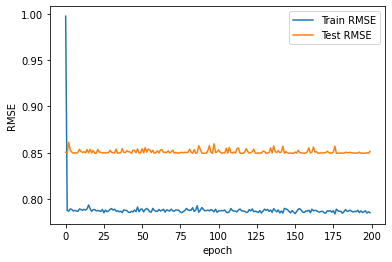

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Prediction
user = ratings_test.users.values[0:5]
track = ratings_test.tracks.values[0:5]
predictions = model.predict([user, track]) + mu
print("Actuals: \n", ratings_test.iloc[0:5])
print()
print("Predictions: \n", predictions)

Actuals: 
       users  tracks  score
3037     18     121   -1.0
3038     18     122    1.0
3039     18     123    1.0
3040     18     124    1.0
3041     18     125    0.0

Predictions: 
 [[0.3445786]
 [0.3445786]
 [0.3445786]
 [0.3445786]
 [0.3445786]]


5

#### Tuner 있는 버전

In [ ]:
EPOCHS = 400
def build_model(hp):
# Keras model

  K = hp.Int('K',min_value=int(0.5*M),max_value=M,step=1)
  user = Input(shape=(1, ))                                               # User input
  item = Input(shape=(1, ))                                               # Item input
  P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
  Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
  user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
  item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

  # Concatenate layers
  
  P_embedding = Flatten()(P_embedding)                                    # (K, )
  Q_embedding = Flatten()(Q_embedding)                                    # (K, )
  user_bias = Flatten()(user_bias)                                        # (1, )
  item_bias = Flatten()(item_bias)                                        # (1, )
  R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

  # Neural network
  case = hp.Int('Case' , min_value=1,max_value=2,step=1)
  if case ==1:
    neurons = hp.Int('Nuerons' , min_value=16,max_value=128,step=16)
    R = Dense(neurons,activation='relu',kernel_initializer='he_uniform')(R)
  
  elif case ==2:
    neuron_1 = hp.Int('Nuerons' , min_value=64,max_value=128,step=16)
    neuron_2 = int(0.5*neuron_1)
    R = Dense(neuron_1,activation='relu',kernel_initializer='he_uniform')(R)
    R = Dense(neuron_2,activation='relu',kernel_initializer='he_uniform')(R)
  R = Dense(1)(R)


  # Model setting
  starter_learning_rate = 0.1
  end_learning_rate = 0.0001
  decay_steps = int(0.1*EPOCHS)
  learning_rate_fn = PolynomialDecay(
      starter_learning_rate,
      decay_steps,
      end_learning_rate,
      power=0.5)
  
  model = Model(inputs=[user, item], outputs=R)
  optimizer = hp.Choice('Optimizer',['SGD','Adam'])
  if optimizer == 'Adam':
    model.compile(
      loss=RMSE,
      optimizer=Adam(learning_rate=learning_rate_fn),
      metrics=[RMSE]
      
    )
  elif optimizer =='SGD':
    model.compile(
      loss=RMSE,
      optimizer=SGD(learning_rate=learning_rate_fn,momentum=0.9),
      metrics=[RMSE]
    )
  return model

hp = kt.HyperParameters()

# Initialize the tuner by passing the `build_model` function
# and specifying key search constraints: maximize val_acc (objective),
# and the number of trials to do. More efficient tuners like UltraBand() can
# be used.
TRIALS = 30
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=TRIALS,
    project_name="Spotify Recommendation Systems",
)

# Display search space overview
tuner.search_space_summary()

# Perform the model search. The search function has the same signature
# as `model.fit()`.
tuner.search(
    [ratings_train.users.values, ratings_train.tracks.values],ratings_train.score.values - mu,batch_size=64, epochs=EPOCHS, 
    validation_data=([ratings_valid.users.values, ratings_valid.tracks.values], ratings_valid.score.values - mu)
)

# Display the best models, their hyperparameters, and the resulting metrics.
tuner.results_summary()

# Retrieve the best model and display its architecture
best_model = tuner.get_best_models(num_models=1)[0]
result = best_model.fit([ratings_train.users.values, ratings_train.tracks.values],ratings_train.score.values - mu,
               batch_size=64, 
               epochs=EPOCHS,
               validation_data=([ratings_valid.users.values, ratings_valid.tracks.values], ratings_valid.score.values - mu))

Trial 30 Complete [00h 01m 36s]
val_loss: 0.7727070450782776

Best val_loss So Far: 0.7622820734977722
Total elapsed time: 00h 47m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./Spotify Recommendation Systems
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
K: 27
Case: 2
Nuerons: 32
Optimizer: False
Score: 0.7622820734977722
Trial summary
Hyperparameters:
K: 22
Case: 1
Nuerons: 32
Optimizer: True
Score: 0.7622963786125183
Trial summary
Hyperparameters:
K: 14
Case: 2
Nuerons: 112
Optimizer: False
Score: 0.7631160616874695
Trial summary
Hyperparameters:
K: 24
Case: 2
Nuerons: 16
Optimizer: False
Score: 0.7635301351547241
Trial summary
Hyperparameters:
K: 20
Case: 2
Nuerons: 96
Optimizer: False
Score: 0.7645853161811829
Trial summary
Hyperparameters:
K: 15
Case: 2
Nuerons: 64
Optimizer: False
Score: 0.76480633020401
Trial summary
Hyperparameters:
K: 18
Case: 2
Nuerons: 16
Optimizer: False
Score: 0.7654535174369812
Tr

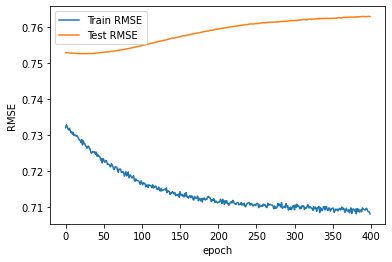

In [ ]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
model=best_model
user_ids = ratings_test.users.values
track_ids = ratings_test.tracks.values
y_pred = model.predict([user_ids, track_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.score)

RMSE2(y_true, y_pred)

0.726

In [ ]:
#fname='/gdrive/Shareddrives/Spotify Recommendation/Recommendation Models/NeuralNet_RandomSearch_210402.h5'
best_model.save('/gdrive/Shareddrives/Spotify Recommendation/Recommendation Models/NeuralNet_RandomSearch_210402.h5')

### (3) Nationality variable Added

In [ ]:
USERS = data_dict['User'][['users','nationality']]

user2idx={name:i for i, name in enumerate(USERS.users)}
for i in range(29):
  USERS.users[i]=user2idx[USERS.users[i]]
USERS

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,users,nationality
0,0,korea
1,1,singapore
2,2,uk
3,3,uk
4,4,uk
5,5,singapore
6,6,singapore
7,7,honkong
8,8,korea
9,9,hongkong


In [ ]:
nationality={}
def convert_nat(x):
    if x in nationality:
        return nationality[x]
    else:
        nationality[x] = len(nationality)
        return nationality[x]
USERS['nationality'] = USERS['nationality'].apply(convert_nat)
USERS;L=len(nationality)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_nat = pd.merge(ratings_train,USERS,on='users')['nationality']
valid_nat = pd.merge(ratings_valid,USERS,on='users')['nationality']
test_nat = pd.merge(ratings_test,USERS,on='users')['nationality']

#### Tuner 없는 버전

In [ ]:
# Variable 초기화 
K = 15
epochs=300                            # Latent factor 수 
mu = round(ratings_train.score.mean(),4)  # 전체 평균 
M = len(ratings.index)    # Number of users
N = len(ratings.columns) # Number of movies
   

# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

nat = Input(shape=(1, ))
nat_embedding = Embedding(L, 3, embeddings_regularizer=l2())(nat)
nat_layer = Flatten()(nat_embedding)


# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, nat_layer])

# Neural network
R = Dense(128,activation='relu',kernel_initializer='he_uniform')(R)
R = Dropout(0.5)(R)
#R = Dense(64,activation='relu',kernel_initializer='he_uniform')(R)
#R = Dropout(0.1)(R)
#R = Dense(32,activation='relu',kernel_initializer='he_uniform')(R)
R = Dense(1)(R)

# Model setting
starter_learning_rate = 0.1
end_learning_rate = 0.0001
decay_steps = int(0.1*epochs)
learning_rate_fn = PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)
model = Model(inputs=[user, item,nat], outputs=R)


model.compile(
  loss=RMSE,
  #optimizer=SGD(learning_rate=learning_rate_fn,momentum=0.9),
  optimizer=Adam(learning_rate=learning_rate_fn),
  metrics=[RMSE],
  
)

model.summary()


# Model fitting
result = model.fit(
  x=[ratings_train.users.values, ratings_train.tracks.values,train_nat.values],
  y=ratings_train.score.values - mu,
  epochs=epochs,
  batch_size=64,
  validation_data=(
    [ratings_test.users.values, ratings_test.tracks.values,test_nat.values],
    ratings_test.score.values - mu
  )
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        435         input_1[0][0]                    
______________________________________________________________________________________________

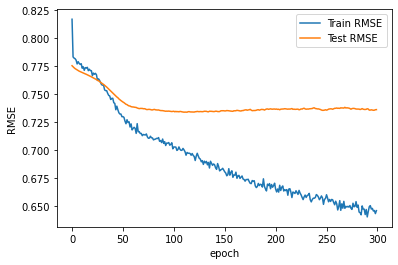

In [ ]:
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
model.save(f'/gdrive/Shareddrives/Spotify Recommendation/Recommendation Models/NeuralNet_Nationality_{today()}.h5')

#### Tuner 있는 버전

In [ ]:
EPOCHS = 400
def build_model(hp):
# Keras model
  
  K = hp.Int('K',min_value=10,max_value=int(0.5*M),step=1)
  # Keras model
  user = Input(shape=(1, ))                                               # User input
  item = Input(shape=(1, ))                                               # Item input
  P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
  Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
  user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
  item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

  nat = Input(shape=(1, ))
  nat_embedding = Embedding(L, int(0.5*L), embeddings_regularizer=l2())(nat)
  nat_layer = Flatten()(nat_embedding)


  # Concatenate layers

  P_embedding = Flatten()(P_embedding)                                    # (K, )
  Q_embedding = Flatten()(Q_embedding)                                    # (K, )
  user_bias = Flatten()(user_bias)                                        # (1, )
  item_bias = Flatten()(item_bias)                                        # (1, )
  R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, nat_layer])

  # Neural network
  case = hp.Int('Case' , min_value=1,max_value=2,step=1)
  if case ==1:
    neurons = hp.Int('Nuerons' , min_value=16,max_value=128,step=16)
    R = Dense(neurons,activation='relu',kernel_initializer='he_uniform')(R)
  
  elif case ==2:
    neuron_1 = hp.Int('Nuerons' , min_value=64,max_value=128,step=16)
    neuron_2 = int(0.5*neuron_1)
    R = Dense(neuron_1,activation='relu',kernel_initializer='he_uniform')(R)
    R = Dense(neuron_2,activation='relu',kernel_initializer='he_uniform')(R)
  #neurons = hp.Int('Nuerons' , min_value=16,max_value=128,step=16)
  #R = Dense(neurons,activation='relu',kernel_initializer='he_uniform')(R)
  
  R = Dense(1)(R)


  # Model setting
  starter_learning_rate = 0.1
  end_learning_rate = 0.0001
  decay_steps = int(0.2*EPOCHS)
  learning_rate_fn = PolynomialDecay(
      starter_learning_rate,
      decay_steps,
      end_learning_rate,
      power=0.1)
  
  model = Model(inputs=[user, item,nat], outputs=R)
  
  optimizer = hp.Choice('Optimizer',['SGD','Adam'])
  if optimizer == 'Adam':
    model.compile(
      loss=RMSE,
      optimizer=Adam(learning_rate=learning_rate_fn),
      metrics=[RMSE]
      
    )
  elif optimizer =='SGD':
    model.compile(
      loss=RMSE,
      optimizer=SGD(learning_rate=learning_rate_fn,momentum=0.9),
      metrics=[RMSE]
    )
  return model

hp = kt.HyperParameters()

# Initialize the tuner by passing the `build_model` function
# and specifying key search constraints: maximize val_acc (objective),
# and the number of trials to do. More efficient tuners like UltraBand() can
# be used.
TRIALS = 20
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=TRIALS,
    project_name=f"{today()}_Spotify Recommendation Systems"
)

# Display search space overview
tuner.search_space_summary()

# Perform the model search. The search function has the same signature
# as `model.fit()`.
tuner.search(
    [ratings_train.users.values, ratings_train.tracks.values,train_nat.values],ratings_train.score.values - mu,batch_size=64, epochs=EPOCHS, 
    validation_data=([ratings_valid.users.values, ratings_valid.tracks.values,valid_nat.values], ratings_valid.score.values - mu)
)

# Display the best models, their hyperparameters, and the resulting metrics.
tuner.results_summary()

# Retrieve the best model and display its architecture
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

best_model = tuner.get_best_models(num_models=1)[0]
result = best_model.fit([ratings_train.users.values, ratings_train.tracks.values,train_nat.values],ratings_train.score.values - mu,
               batch_size=64, 
               epochs=EPOCHS,
               validation_data=([ratings_valid.users.values, ratings_valid.tracks.values,valid_nat.values], ratings_valid.score.values - mu))

Trial 20 Complete [00h 01m 19s]
val_loss: 0.7790916562080383

Best val_loss So Far: 0.758938193321228
Total elapsed time: 00h 24m 26s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./20210405_13시18분_Spotify Recommendation Systems
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
K: 11
Case: 2
Nuerons: 80
Optimizer: SGD
Score: 0.758938193321228
Trial summary
Hyperparameters:
K: 11
Case: 2
Nuerons: 96
Optimizer: Adam
Score: 0.7643963694572449
Trial summary
Hyperparameters:
K: 11
Case: 2
Nuerons: 96
Optimizer: SGD
Score: 0.7659991383552551
Trial summary
Hyperparameters:
K: 13
Case: 1
Nuerons: 128
Optimizer: SGD
Score: 0.7669990062713623
Trial summary
Hyperparameters:
K: 12
Case: 1
Nuerons: 48
Optimizer: SGD
Score: 0.768923819065094
Trial summary
Hyperparameters:
K: 13
Case: 1
Nuerons: 32
Optimizer: SGD
Score: 0.7701215744018555
Trial summary
Hyperparameters:
K: 12
Case: 2
Nuerons: 48
Optimizer: SGD
Score: 0.7705223560333252

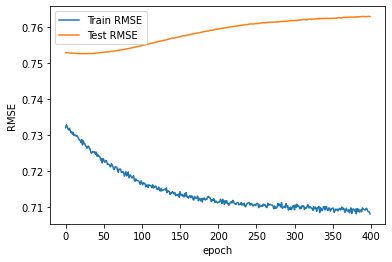

In [ ]:
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
model=best_model
user_ids = ratings_test.users.values
track_ids = ratings_test.tracks.values
nat_ids = test_nat.values
y_pred = model.predict([user_ids, track_ids,nat_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.score)

display(RMSE2(y_true, y_pred))
y_pred=list(y_pred)

0.725

In [ ]:
model.save(f'/gdrive/Shareddrives/Spotify Recommendation/Recommendation Models/NeuralNet_Nationality_{today()}.h5')

### get_top_n

In [ ]:
def NN_top_n(predictions,n=5):
  temp=defaultdict(list)
  for uidx,iidx,nat,est in zip(user_ids,track_ids,nat_ids,y_pred):
    temp[idx2user[uidx]].append((idx2track[iidx],est))

  for uid,user_ratings in temp.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    temp[uid] = user_ratings[:n]

  return temp

def NN_Recommend(uid,top_n):
  if uid =='윤지현':
    print(f'<{uid} (a.k.a. 윤영롱) 님을 위한 추천곡>\n')
  else:
    print(f'<{uid} 님을 위한 추천곡>\n')
  for (iid,est) in top_n[uid]:
    print(f'{iid} => {round(round(est,4)*100,2)} %의 확률로 좋아하실 거에요')
top_n = NN_top_n(y_pred)
Recommend('도윤',top_n)

<도윤 님을 위한 추천곡>

Billie Jean__Michael Jackson => 86.27 %의 확률로 좋아하실 거에요
I'm the One__DJ Khaled => 83.2 %의 확률로 좋아하실 거에요
Hold On, We're Going Home__Drake => 71.49 %의 확률로 좋아하실 거에요
Levels - Radio Edit__Avicii => 68.89 %의 확률로 좋아하실 거에요
Take Care__Drake => 47.19 %의 확률로 좋아하실 거에요


# Hybrid : CF + MF

In [ ]:
# CF 추천 알고리즘
rating_matrix = ratings_train.pivot(index='users', columns='movieId', values='rating')

# train set 사용자들의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# train 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id]
        movie_ratings = rating_bias[movie_id]
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]
        else:
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction


In [ ]:
# MF 추천 알고리즘
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        prediction = self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
        return prediction

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

# MF클래스 생성 및 학습
R_temp = ratings.pivot(index='users', columns='movieId', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=200, alpha=0.001, beta=0.02, iterations=250, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()


Iteration: 10 ; Train RMSE = 0.8609 ; Test RMSE = 0.7942
Iteration: 20 ; Train RMSE = 0.8380 ; Test RMSE = 0.8002
Iteration: 30 ; Train RMSE = 0.8255 ; Test RMSE = 0.8046
Iteration: 40 ; Train RMSE = 0.8173 ; Test RMSE = 0.8070
Iteration: 50 ; Train RMSE = 0.8115 ; Test RMSE = 0.8082
Iteration: 60 ; Train RMSE = 0.8073 ; Test RMSE = 0.8089
Iteration: 70 ; Train RMSE = 0.8041 ; Test RMSE = 0.8093
Iteration: 80 ; Train RMSE = 0.8017 ; Test RMSE = 0.8096
Iteration: 90 ; Train RMSE = 0.7998 ; Test RMSE = 0.8100
Iteration: 100 ; Train RMSE = 0.7984 ; Test RMSE = 0.8104
Iteration: 110 ; Train RMSE = 0.7972 ; Test RMSE = 0.8108
Iteration: 120 ; Train RMSE = 0.7961 ; Test RMSE = 0.8111
Iteration: 130 ; Train RMSE = 0.7953 ; Test RMSE = 0.8115
Iteration: 140 ; Train RMSE = 0.7945 ; Test RMSE = 0.8118
Iteration: 150 ; Train RMSE = 0.7937 ; Test RMSE = 0.8122
Iteration: 160 ; Train RMSE = 0.7929 ; Test RMSE = 0.8125
Iteration: 170 ; Train RMSE = 0.7921 ; Test RMSE = 0.8127
Iteration: 180 ; Train 

In [ ]:
# HYBRID 추천 알고리즘
def recommender0(recomm_list, mf):
    recommendations = np.array([mf.get_one_prediction(user, movie) for (user, movie) in recomm_list])
    return recommendations

def recommender1(recomm_list, neighbor_size=0):
    recommendations = np.array([CF_knn_bias(user, movie, neighbor_size) for (user, movie) in recomm_list])
    return recommendations

recomm_list = np.array(ratings_test.iloc[:, [0, 1]])
predictions0 = recommender0(recomm_list, mf)
RMSE2(ratings_test.iloc[:, 2], predictions0)
predictions1 = recommender1(recomm_list, 37)
RMSE2(ratings_test.iloc[:, 2], predictions1)

weight = [0.8, 0.2]
predictions = predictions0 * weight[0] + predictions1 * weight[1]
RMSE2(ratings_test.iloc[:, 2], predictions)

for i in np.arange(0, 1, 0.01):
    weight = [i, 1.0 - i]
    predictions = predictions0 * weight[0] + predictions1 * weight[1]
    print("Weights - %.2f : %.2f ; RMSE = %.7f" % (weight[0], 
           weight[1], RMSE2(ratings_test.iloc[:, 2], predictions)))


Weights - 0.00 : 1.00 ; RMSE = 0.7492532
Weights - 0.01 : 0.99 ; RMSE = 0.7493927
Weights - 0.02 : 0.98 ; RMSE = 0.7495428
Weights - 0.03 : 0.97 ; RMSE = 0.7497035
Weights - 0.04 : 0.96 ; RMSE = 0.7498746
Weights - 0.05 : 0.95 ; RMSE = 0.7500563
Weights - 0.06 : 0.94 ; RMSE = 0.7502485
Weights - 0.07 : 0.93 ; RMSE = 0.7504511
Weights - 0.08 : 0.92 ; RMSE = 0.7506643
Weights - 0.09 : 0.91 ; RMSE = 0.7508880
Weights - 0.10 : 0.90 ; RMSE = 0.7511221
Weights - 0.11 : 0.89 ; RMSE = 0.7513667
Weights - 0.12 : 0.88 ; RMSE = 0.7516218
Weights - 0.13 : 0.87 ; RMSE = 0.7518873
Weights - 0.14 : 0.86 ; RMSE = 0.7521632
Weights - 0.15 : 0.85 ; RMSE = 0.7524495
Weights - 0.16 : 0.84 ; RMSE = 0.7527463
Weights - 0.17 : 0.83 ; RMSE = 0.7530535
Weights - 0.18 : 0.82 ; RMSE = 0.7533710
Weights - 0.19 : 0.81 ; RMSE = 0.7536989
Weights - 0.20 : 0.80 ; RMSE = 0.7540372
Weights - 0.21 : 0.79 ; RMSE = 0.7543858
Weights - 0.22 : 0.78 ; RMSE = 0.7547447
Weights - 0.23 : 0.77 ; RMSE = 0.7551140
Weights - 0.24 :